### Load dataframe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos_call"

In [6]:
DT_ID = '2022-03-12_17-46-00'

In [7]:
call_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'call_df_for_umap.pickle')
call_df[:3]

,start_time,end_time,ID,labels,start_times,end_times,call_unique_num,call_pos_combi,combi_label,combi_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
0,0.753604,0.921160,0,DSSHDS,0.753604,0.921160,0,0,DSSHDS SHSHLH,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
1,0.932017,1.367130,1,SHSHLH,0.932017,1.367130,1,1,DSSHDS SHSHLH,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH
0,1.218085,1.308841,2,DS,1.218085,1.308841,2,0,DS USC,1,...,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS,DS SH-LH


In [9]:
call_df.sort_values(by=['ID'])
call_df[:2]

,start_time,end_time,ID,labels,start_times,end_times,call_unique_num,call_pos_combi,combi_label,combi_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
0,0.753604,0.92116,0,DSSHDS,0.753604,0.92116,0,0,DSSHDS SHSHLH,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
1,0.932017,1.36713,1,SHSHLH,0.932017,1.36713,1,1,DSSHDS SHSHLH,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH


In [10]:
len(call_df)

561

BMYO 37


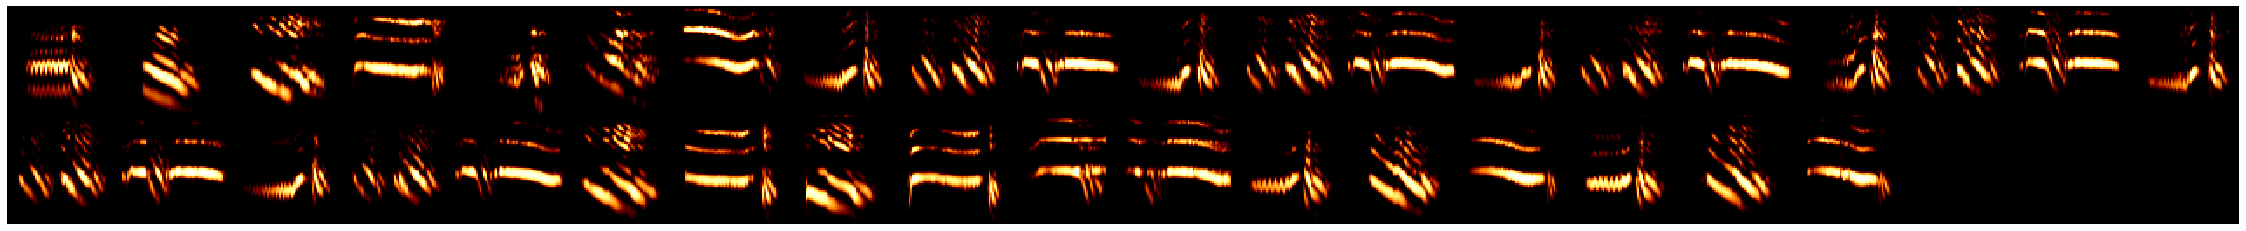

GBYM 33


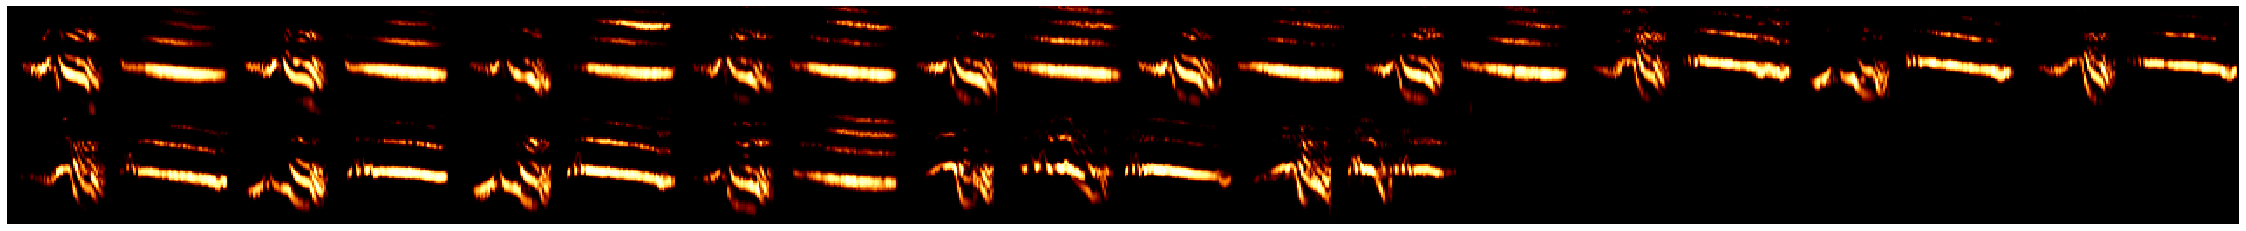

GON XF 19-21 15


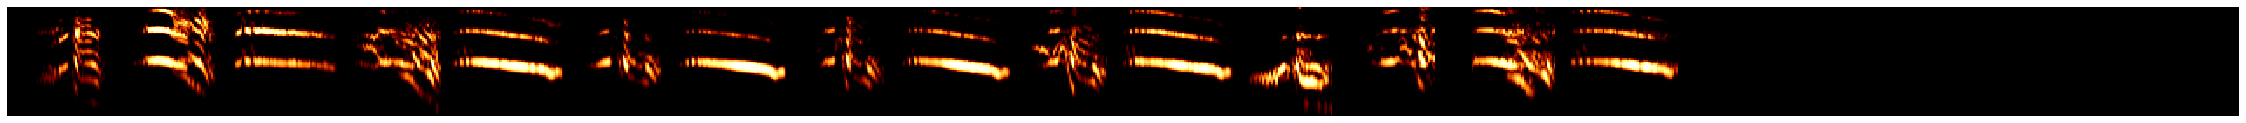

GON XM 20-21 6


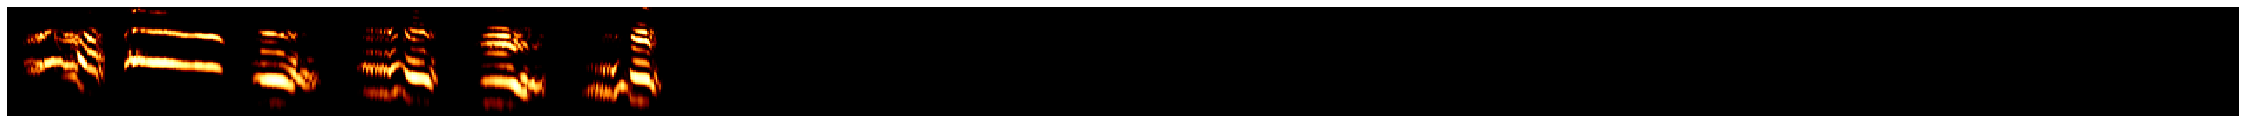

MGGY 32


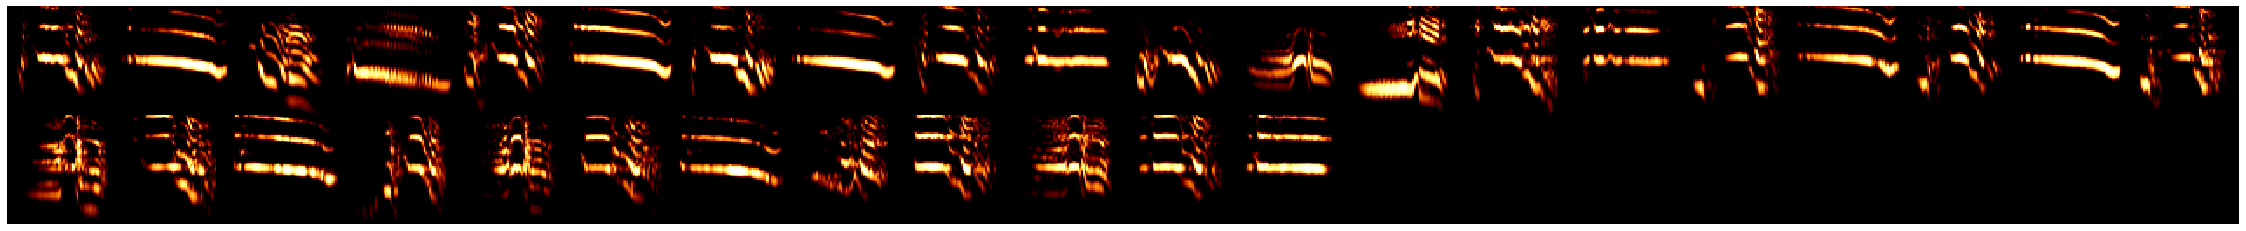

MOGO 40


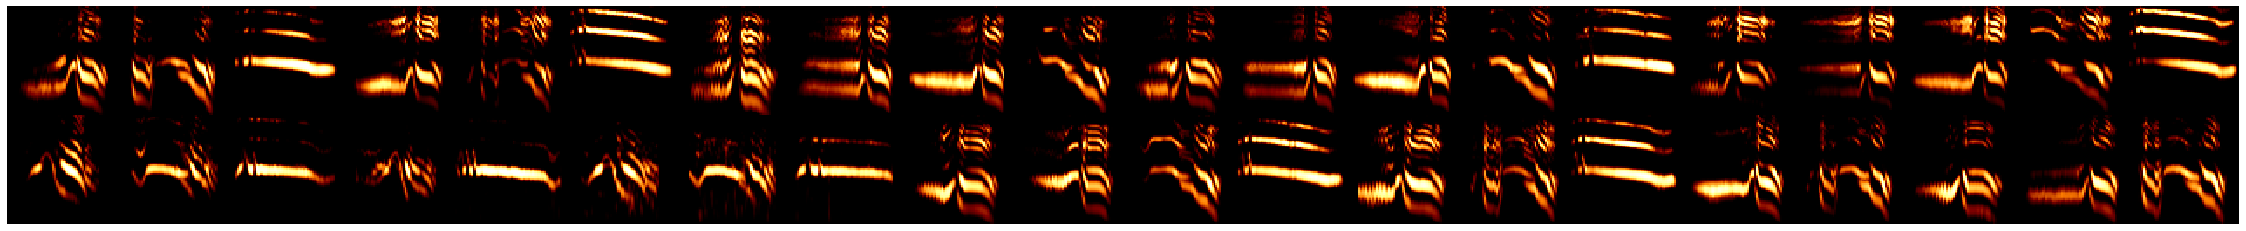

MOOO 13


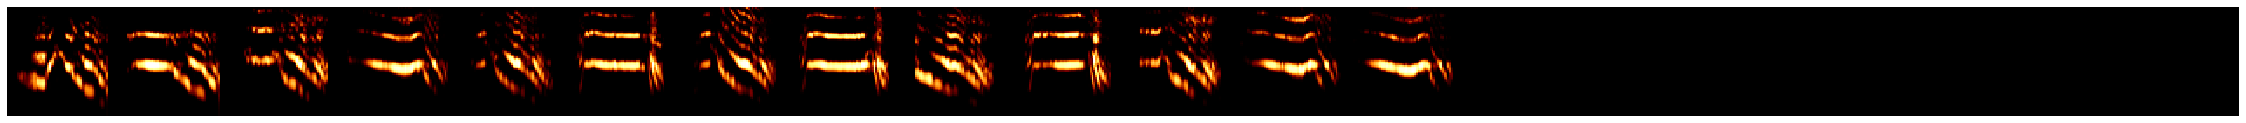

MORP 11


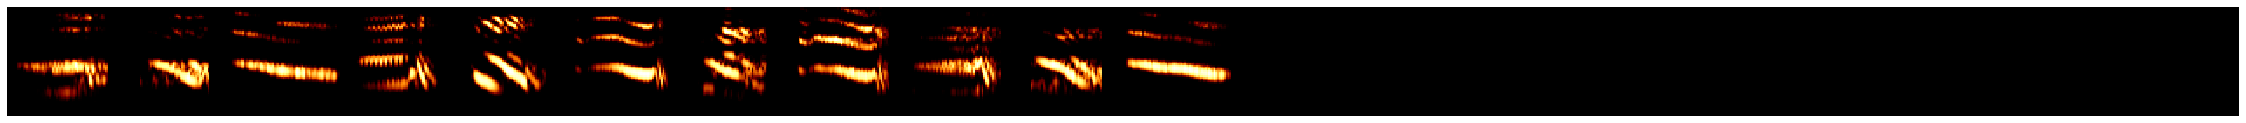

MOVY 10


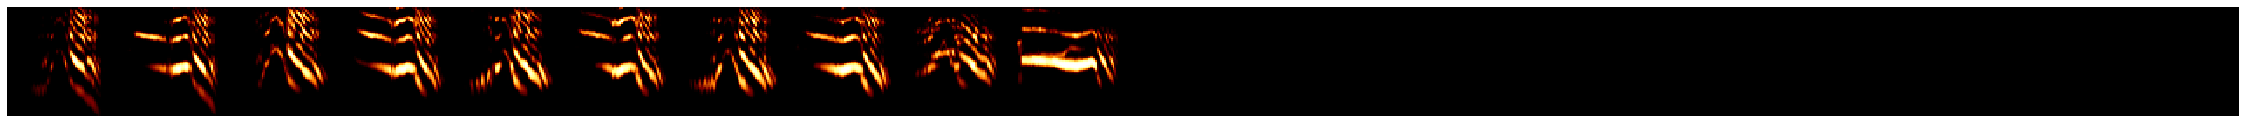

MRGO 44


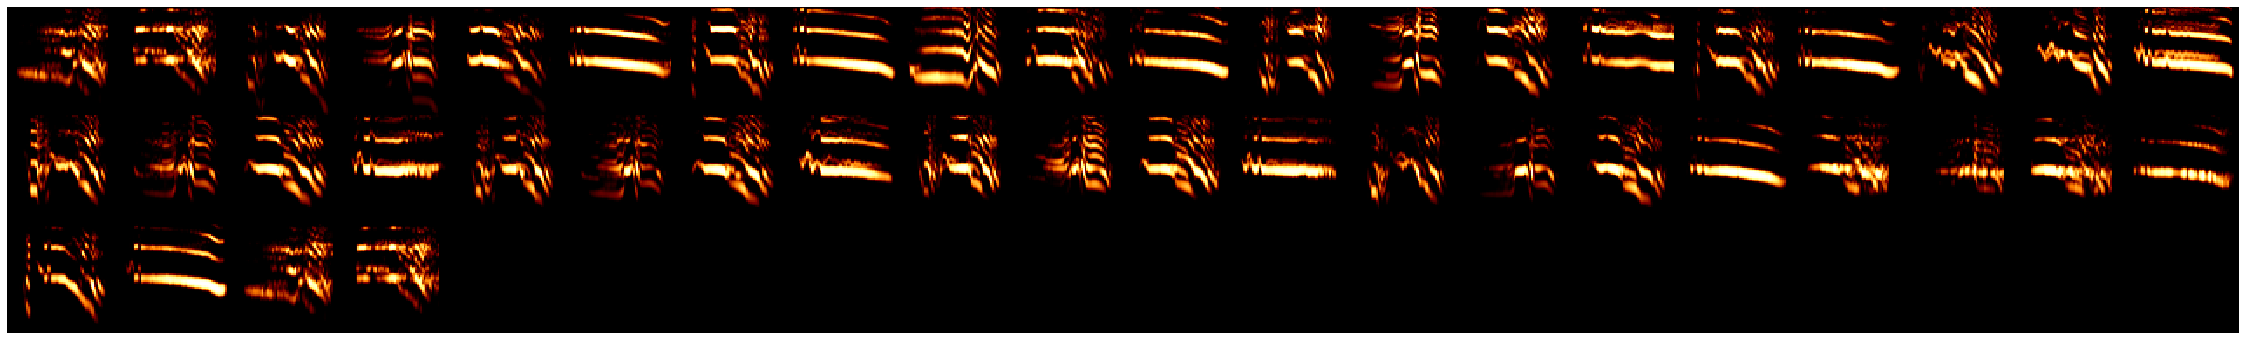

MXWW 23


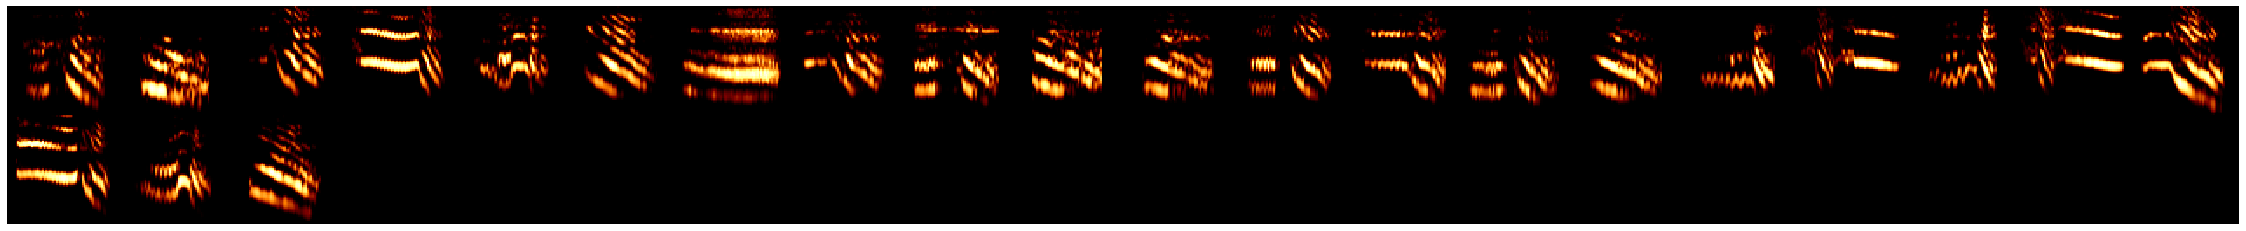

MXXBYX 2


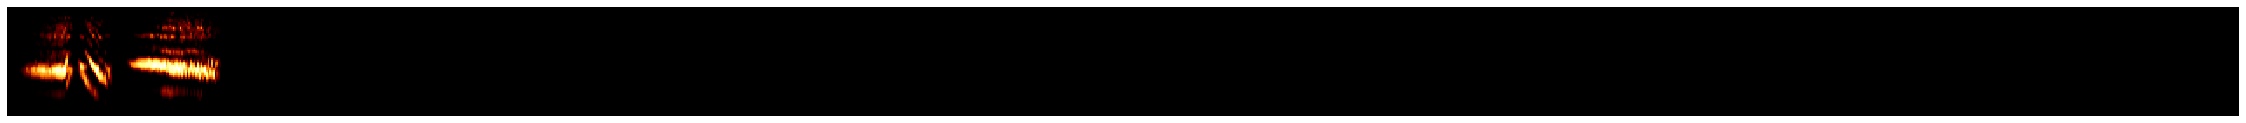

MXXGRY 36


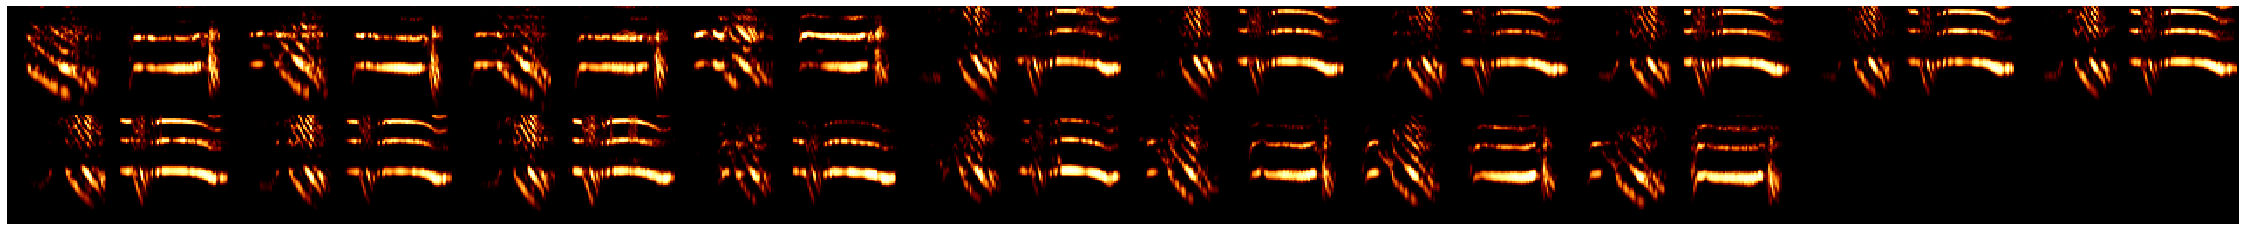

OMGO 52


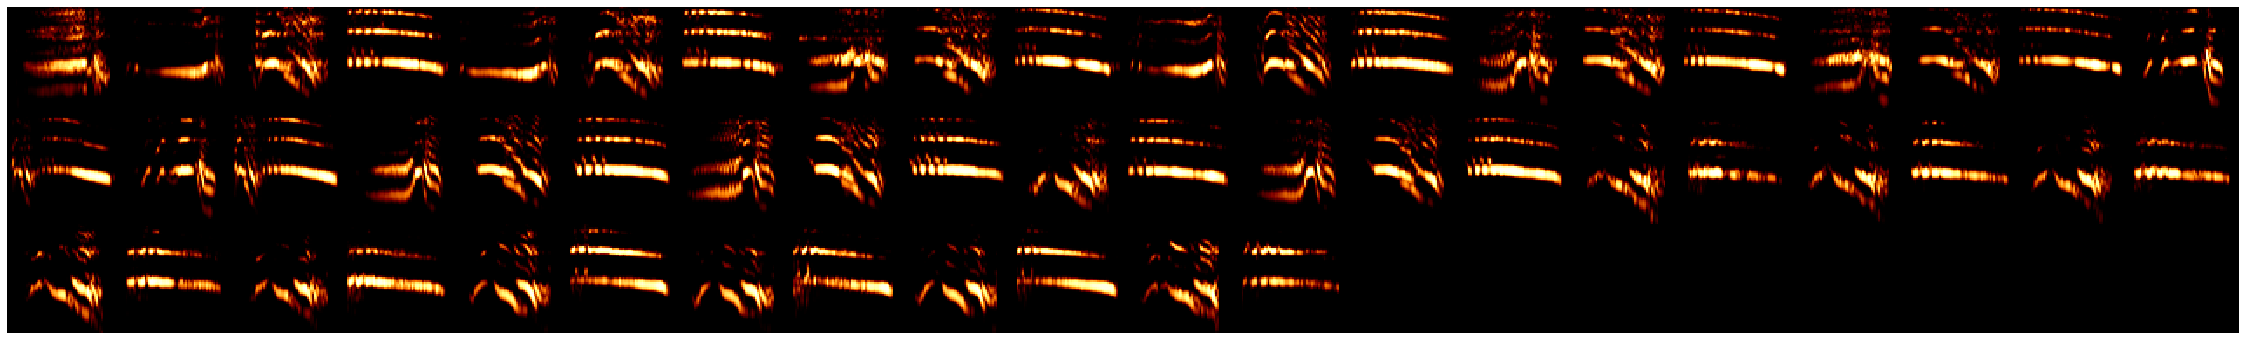

PMXRMX 7


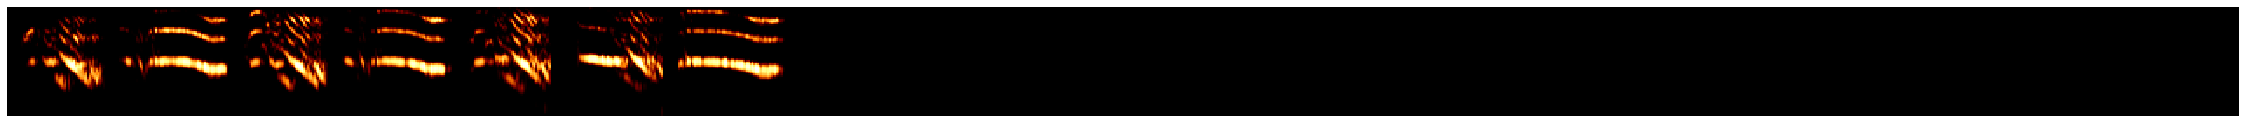

RMXGMX 40


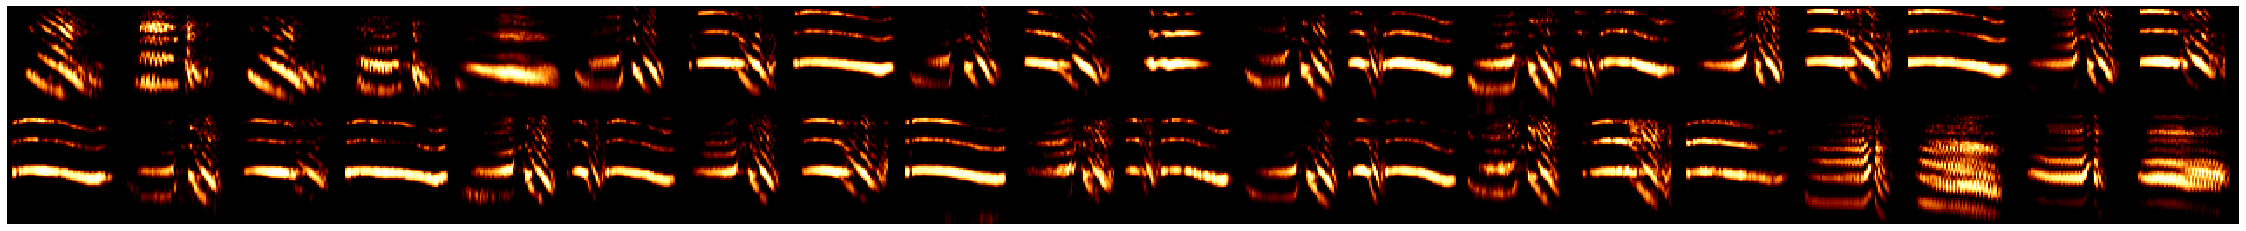

RMYG 19


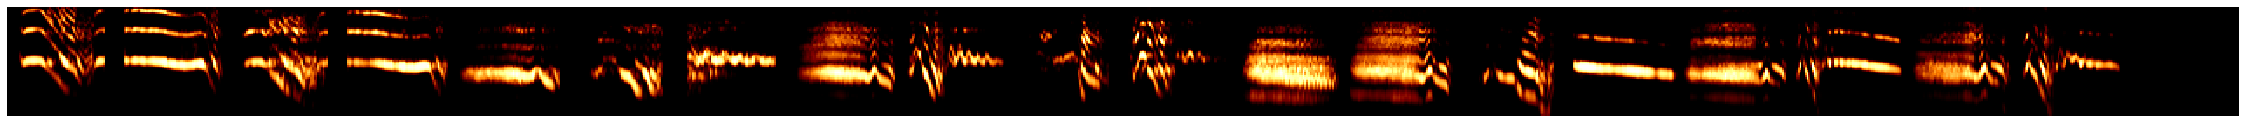

RYMR 7


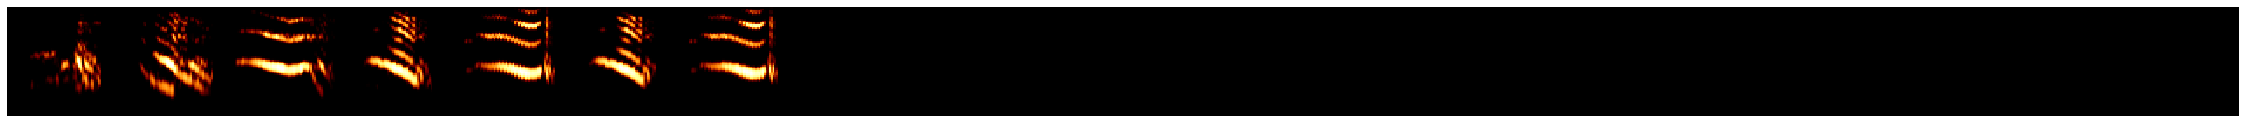

SCL XF 20-21 16


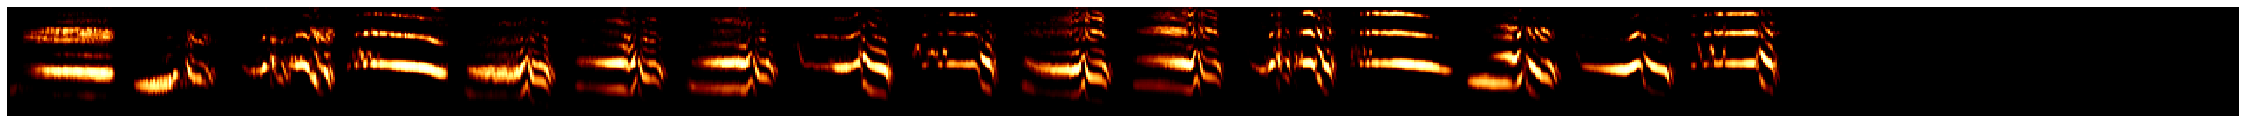

SCL XM 20-21 8


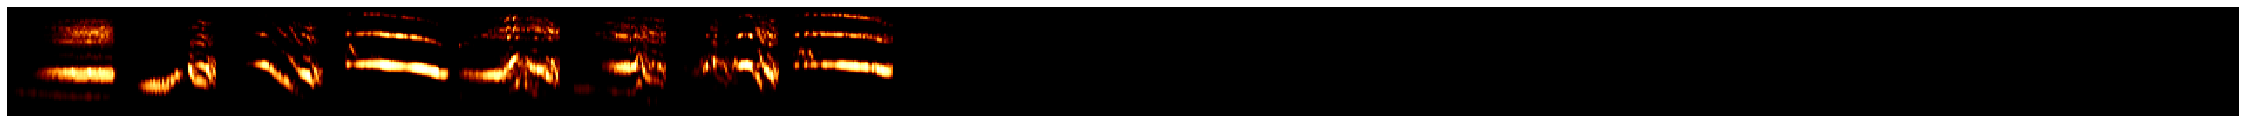

VVOM 30


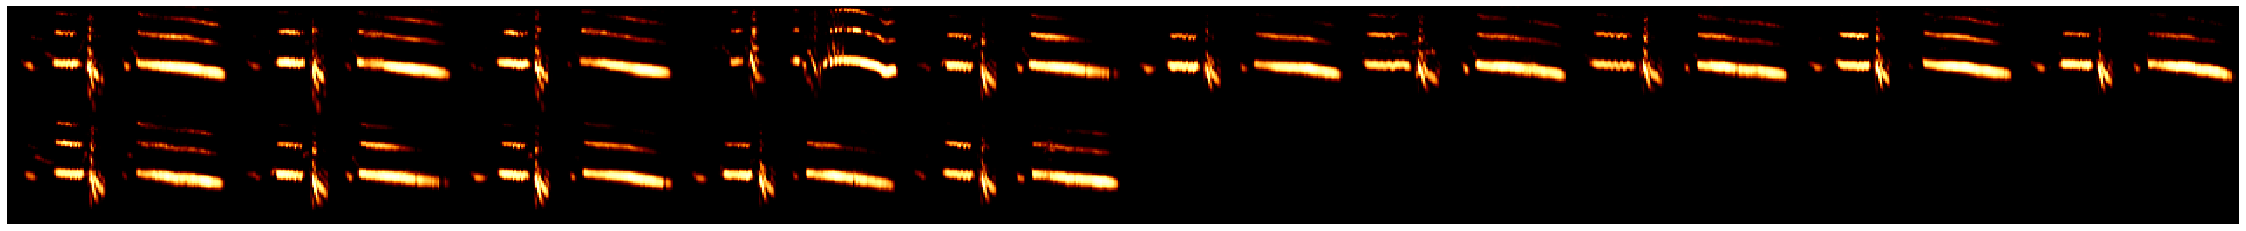

VVVM 67


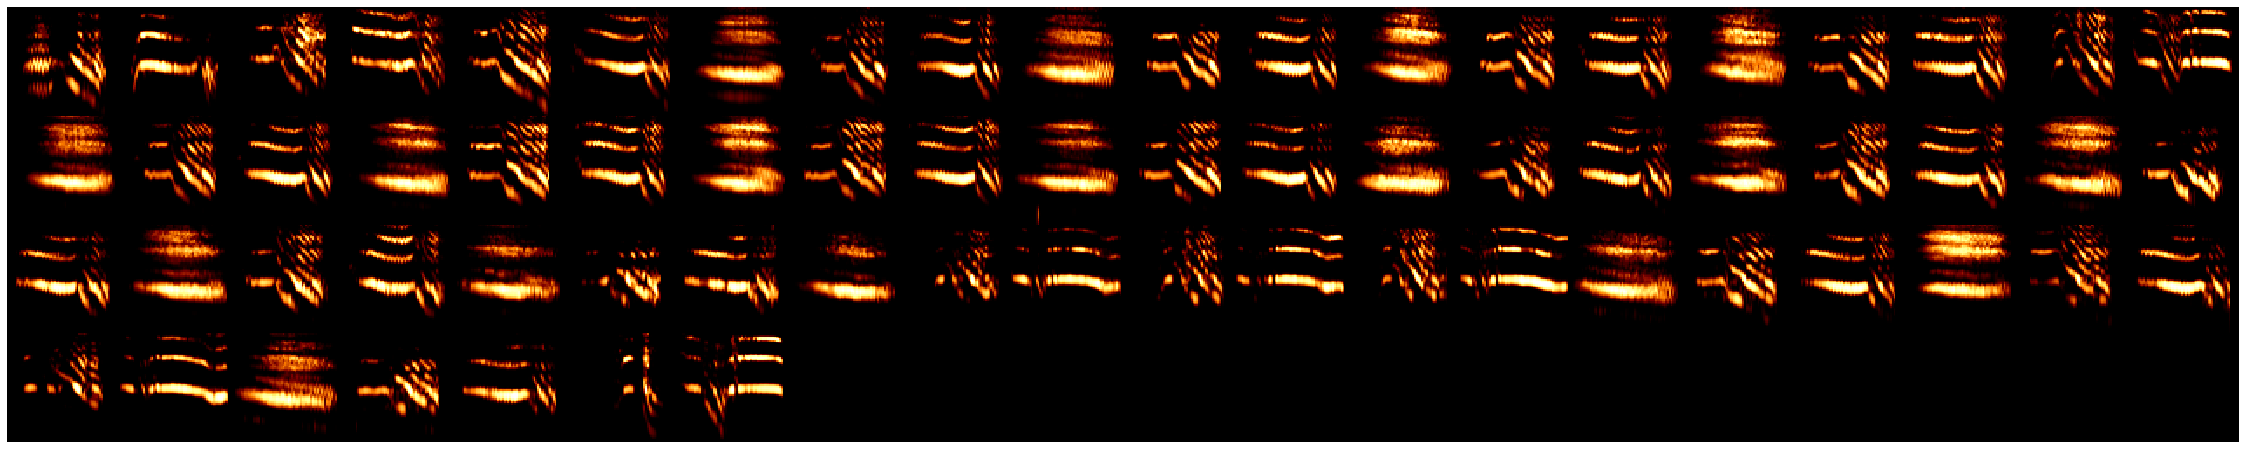

XF 20-21 13


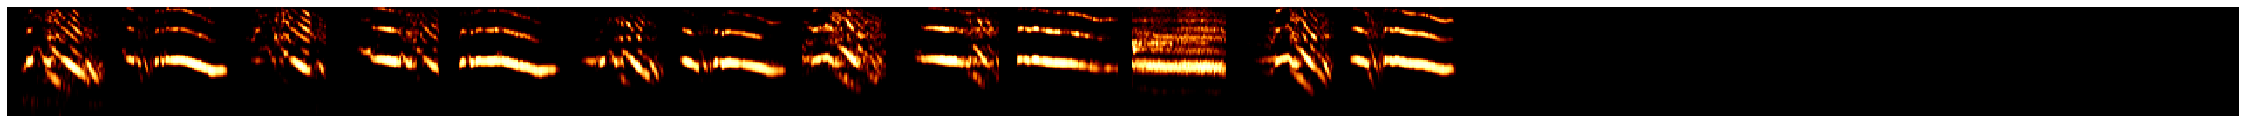

In [19]:
for indv in np.sort(call_df.indv.unique()[:]):
    print(indv, np.sum(call_df.indv == indv))
    specs = np.array([i/np.max(i) for i in call_df[call_df.indv == indv].specs.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [20]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [21]:
call_df = call_df[np.array([np.sum(i) > 0.0 for i in call_df.specs.values])
]

In [22]:
specs = list(call_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/561 [00:00<?, ?it/s]

(561, 4096)

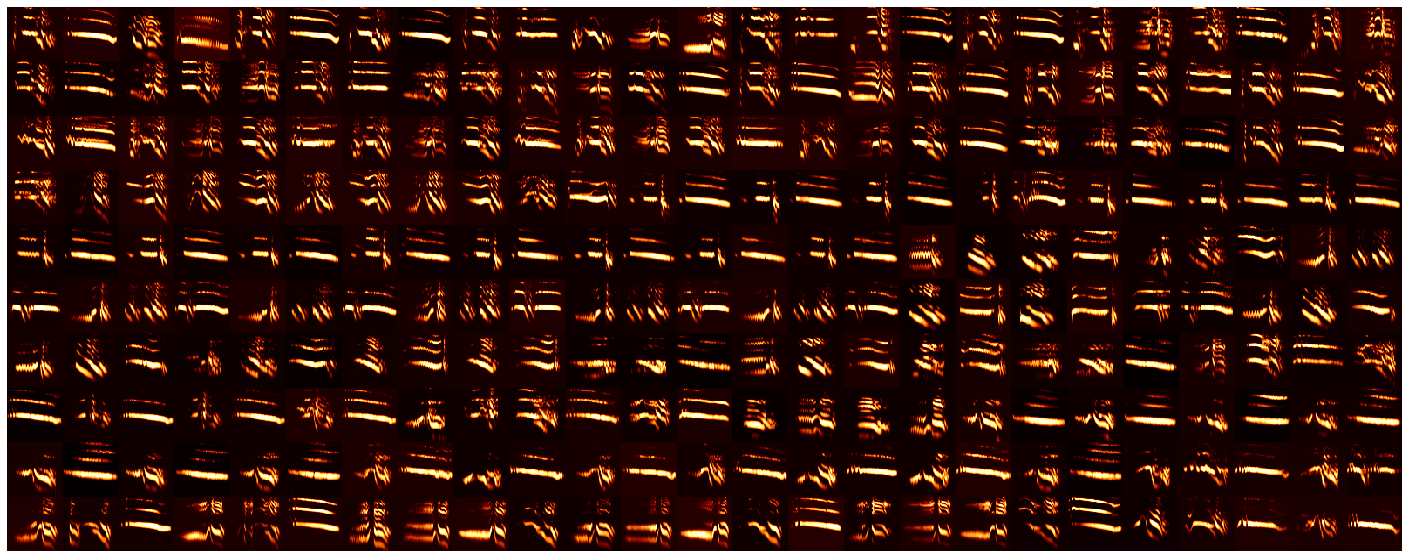

In [23]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [24]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Aug 18 02:57:40 2022 Finding Nearest Neighbors
Thu Aug 18 02:57:41 2022 Finished Nearest Neighbor Search
Thu Aug 18 02:57:43 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Aug 18 02:57:45 2022 Finished embedding


In [27]:
call_df['umap'] = list(z)

### Export to pickle

In [33]:
#save df
save_loc = DATA_DIR / DATASET_ID / DT_ID /  'call_umap.pickle'
ensure_dir(save_loc.as_posix())
call_df.to_pickle(save_loc)